# Integrator Example

In [1]:
import os
current_wd = os.getcwd()
os.chdir(current_wd.split("scikit-identification")[0] + "scikit-identification")
from skmid.models import generate_model_attributes, DynamicModel
from skmid.integrator import RungeKutta4
os.chdir(current_wd)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import chirp

In [3]:
if "skmid" in plt.style.available:
    plt.style.use("skmid")

## Initial Parameters

In [4]:
# Choose an excitation signal
np.random.seed(42)
N = 2000  # Number of samples
fs = 500  # Sampling frequency [hz]
t = np.linspace(0, (N - 1) * (1 / fs), N)
df_input = pd.DataFrame(
    data={
        "u1": 2 * chirp(t, f0=1, f1=10, t1=5, method="logarithmic"),
        "u2": 2 * np.random.random(N),
    },
    index=t,
)

x0 = [1, -1]  # Initial Condition x0 = [0;0]; [nx = 2]

parameter_dict={"N": N, 
                "fs": fs, 
                "t": t, 
                "x0": x0}
print("Initial Parameters")
print(parameter_dict)
display(df_input.head())
print(df_input.shape)

Initial Parameters
{'N': 2000, 'fs': 500, 't': array([0.000e+00, 2.000e-03, 4.000e-03, ..., 3.994e+00, 3.996e+00,
       3.998e+00]), 'x0': [1, -1]}


,u1,u2
0.000,2.000000,0.749080
0.002,1.999842,1.901429
0.004,1.999367,1.463988
0.006,1.998575,1.197317
0.008,1.997465,0.312037


(2000, 2)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


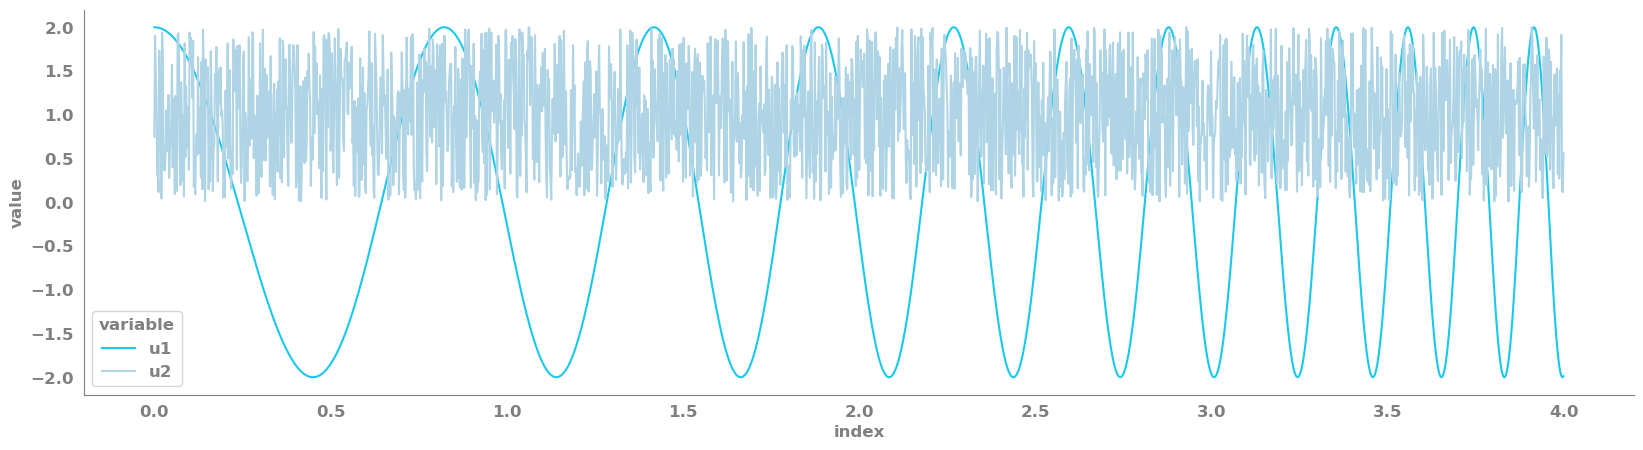

In [5]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df_input
                .reset_index()
                .melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable"
                )
_ = sns.despine()

## Symbolics

In [6]:
(x, u, param) = generate_model_attributes(state_size=2, input_size=2, parameter_size=2)

# assign specific name
x1, x2 = x[0], x[1]
u1, u2 = u[0], u[1]
ka, kb = param[0], param[1]

param_truth = [0.1, 0.5]  # ca.DM([0.1, 0.5])

rhs = [u1 - ka * x1, u1 * u2 / x1 - u1 * x2 / x1 - kb * x2]

symbolics_dict = {"x": x, 
                "u": u, 
                "param": param, 
                "x1": x1, 
                "x2": x2, 
                "u1": u1, 
                "u2": u2, 
                "ka": ka, 
                "kb": kb, 
                "param_truth": param_truth,
                "rhs": rhs
                }
print("Symbolics")
print(symbolics_dict)

Symbolics
{'x': MX(x), 'u': MX(u), 'param': MX(p), 'x1': MX(x[0]), 'x2': MX(x[1]), 'u1': MX(u[0]), 'u2': MX(u[1]), 'ka': MX(p[0]), 'kb': MX(p[1]), 'param_truth': [0.1, 0.5], 'rhs': [MX((u[0]-(p[0]*x[0]))), MX(@1=u[0], @2=x[0], @3=x[1], ((((@1*u[1])/@2)-((@1*@3)/@2))-(p[1]*@3)))]}


## Define the Dynamic Model

In [7]:
sys = DynamicModel(state=x, input=u, parameter=param, model_dynamics=rhs)
sys.print_summary()

Input Summary
-----------------
states    = ['x1', 'x2']
inputs    = ['u1', 'u2']
parameter = ['p1', 'p2']
output    = ['x1', 'x2']

Dimension Summary
-----------------
 Number of inputs: 3
  Input 0 ("x(t)"): 2x1
  Input 1 ("u(t)"): 2x1
  Input 2 ("p"): 2x1
 Number of outputs: 1
  Output 0 ("xdot(t) = f(x(t), u(t), p)"): 2x1


## Run the forward simulation and save the output as a data frame

In [8]:
rk4 = RungeKutta4(model=sys, fs=fs)
rk4.simulate(initial_condition=x0, input=df_input, parameter=param_truth)

df_sim = rk4.output_sim_

display(df_sim.head())
print(df_sim.shape)

,x1,x2
0.000,1.000000,-1.000000
0.002,1.003800,-0.992037
0.004,1.007598,-0.979568
0.006,1.011395,-0.968936
0.008,1.015189,-0.959445


(2001, 2)


## Plot the output

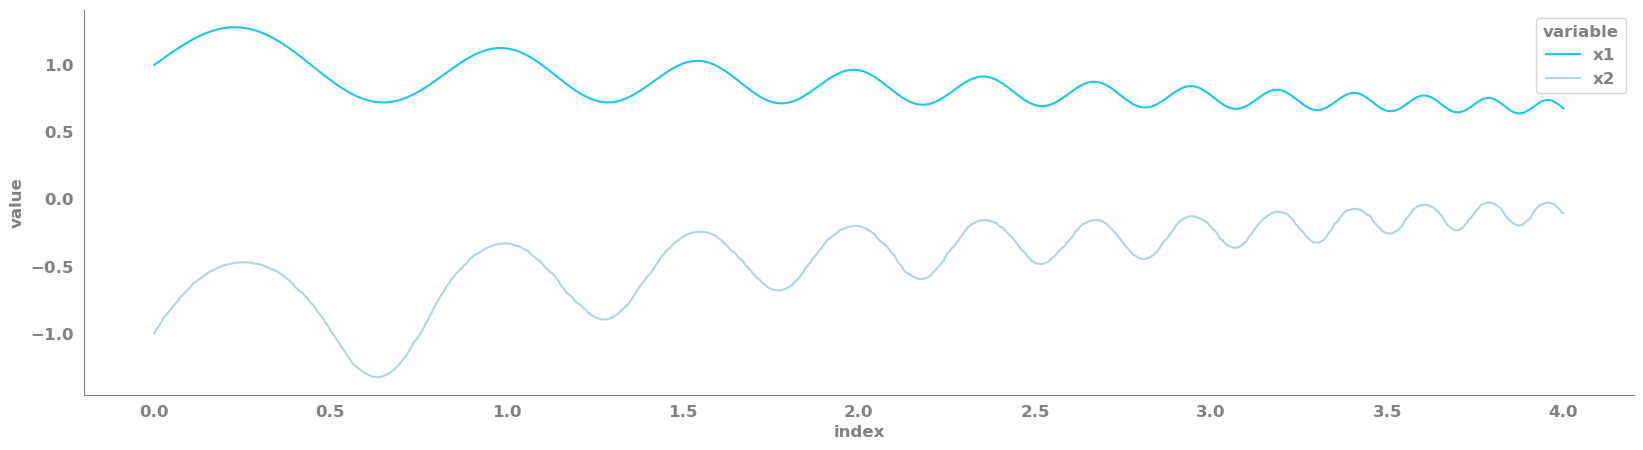

In [9]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df_sim
                .reset_index()
                .melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable"
                )
_ = sns.despine()

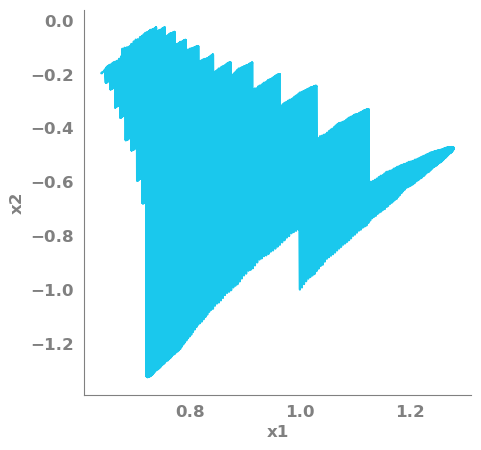

In [10]:
_ = plt.figure(figsize=(5, 5))
_ = sns.lineplot(data=df_sim,
                x="x1",
                y="x2",
                )
_ = sns.despine()